# Analisis Data Hotel Bookings
Data ini dipublikasikan di https://www.sciencedirect.com/science/article/pii/S2352340918315191.




## Data Preprocessing

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
import io
%matplotlib inline
sns.set_style('whitegrid')

In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/kevinasyraf/find-it-2020-dac/master/hotel_bookings.csv')
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,7/1/2015
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,7/2/2015
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,7/3/2015


In [0]:
data.shape

(119390, 32)

In [0]:
# cek tipe data masing-masing atribut
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
hotel                             119390 non-null object
is_canceled                       119390 non-null int64
lead_time                         119390 non-null int64
arrival_date_year                 119390 non-null int64
arrival_date_month                119390 non-null object
arrival_date_week_number          119390 non-null int64
arrival_date_day_of_month         119390 non-null int64
stays_in_weekend_nights           119390 non-null int64
stays_in_week_nights              119390 non-null int64
adults                            119390 non-null int64
children                          119386 non-null float64
babies                            119390 non-null int64
meal                              119390 non-null object
country                           118902 non-null object
market_segment                    119390 non-null object
distribution_channel              119390 n

In [0]:
# cek data yang hilang
data.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Dari data-data yang hilang, perlu dilakukan observasi untuk mengisi data-data nya. <br>
Pada atribut *agent*, bisa diisi dengan 0. <br>
Pada atribut *company* begitu banyak data yang hilang, sehingga kolom ini tidak apa-apa untuk dihapus. <br>
Pada atribut *country* bisa diisi dengan *Unknown* karena asal negara yang tidak diketahui. <br>
Pada atribut *children* kita bisa mengisi data children yang null dengan angka 0.

In [0]:
data = data.drop('company', axis = 1)

In [0]:
data = data.fillna({
    'children' : 0,
    'agent' : 0,
    'country': 'Unknown',
})

In [0]:
# Memastikan tidak ada data yang hilang
any(data.isna().sum())

False

In [0]:
# Selama observasi data, kami menemukan beberapa baris yang mana
# adult = 0, children = 0, dan babies = 0. Maka baris yang mengandung data
# sepert ini sebaiknya di drop dikarenakan tidak mungkin ada hotel dibooking
# dengan tamu berjumlah nol

zero_guests = list(data.loc[data["adults"]
                   + data["children"]
                   + data["babies"]==0].index)
data.drop(data.index[zero_guests], inplace=True)

In [0]:
data.shape

(119210, 31)

## EDA

Akan ada beberapa pertanyaan yang akan dijawab dalam EDA ini

### **1. Mendeteksi Outlier**

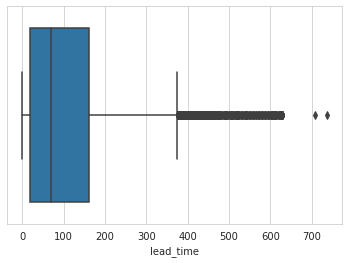

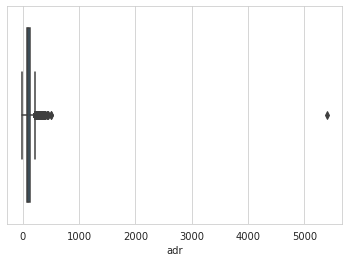

In [0]:
sns.boxplot(data=data, x = 'lead_time')
plt.show()

sns.boxplot(data=data, x = 'adr')
plt.show()

In [0]:
IQR_lt = data['lead_time'].quantile(0.75) -  data['lead_time'].quantile(0.25)
RUB = data['lead_time'].quantile(0.75) + 1.5*IQR_lt

data_no_outlier = data[data['lead_time'] <= RUB]

In [0]:
IQR_adr = data['adr'].quantile(0.75) -  data['adr'].quantile(0.25)
RUB = data['adr'].quantile(0.75) + 1.5*IQR_adr

data_no_outlier = data_no_outlier[data_no_outlier['adr'] <= RUB]

### **2. Dari negara mana saja para tamu berasal?** 

In [0]:
data_country = pd.DataFrame(data.loc[data['is_canceled'] != 1]['country'].value_counts())
data_country.index.name = 'country'
data_country.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = data_country["Number of Guests"].sum()
data_country["Guests in %"] = round(data_country["Number of Guests"] / total_guests * 100, 2)
data_country.head(10) # 10 negara dengan banyak tamu terbanyak

,Number of Guests,Guests in %
country,,
PRT,20977,27.97
GBR,9668,12.89
FRA,8468,11.29
ESP,6383,8.51
DEU,6067,8.09
IRL,2542,3.39
ITA,2428,3.24
BEL,1868,2.49
NLD,1716,2.29


Dari data negara di atas, negara Portugal mendominasi untuk negara asal tamu di hotel.

In [0]:
import plotly.express as px
guest_map = px.choropleth(data_country,
                    locations=data_country.index,
                    color=data_country["Guests in %"], 
                    hover_name=data_country.index, 
                    color_continuous_scale=px.colors.sequential.Viridis,
                    title="Negara asal para tamu hotel")
guest_map.show()

Berdasarkan visualisasi data di atas. Hotel ini sudah dikunjungi oleh turis dari hampir seluruh negara. Negara yang diwarnai putih artinya belum pernah ada turis dari negara tersebut yang mengunjungi hotel.<br>
Negara-negara di Eropa yang banyak mengunjungi hotel ini.

### **3. Banyak tamu perbulan berdasarkan hotel setiap tahunnya** 

In [0]:
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
guest_data = data[data['is_canceled'] == 0].copy()
guests_monthly = guest_data[['hotel', 'arrival_date_year', 'arrival_date_month', 'adults', 'children', 'babies']].sort_values('arrival_date_year')
guests_monthly['total visitors'] = guests_monthly['adults'] + guests_monthly['children'] + guests_monthly['babies']
guests_monthly = guests_monthly.astype({'total visitors' : int})
guests_monthly = guests_monthly.drop(['adults', 'children', 'babies'], axis=1)
guests_monthly.head()

,hotel,arrival_date_year,arrival_date_month,total visitors
0,Resort Hotel,2015,July,2
43256,City Hotel,2015,September,2
43257,City Hotel,2015,September,2
43258,City Hotel,2015,September,2
43259,City Hotel,2015,September,2


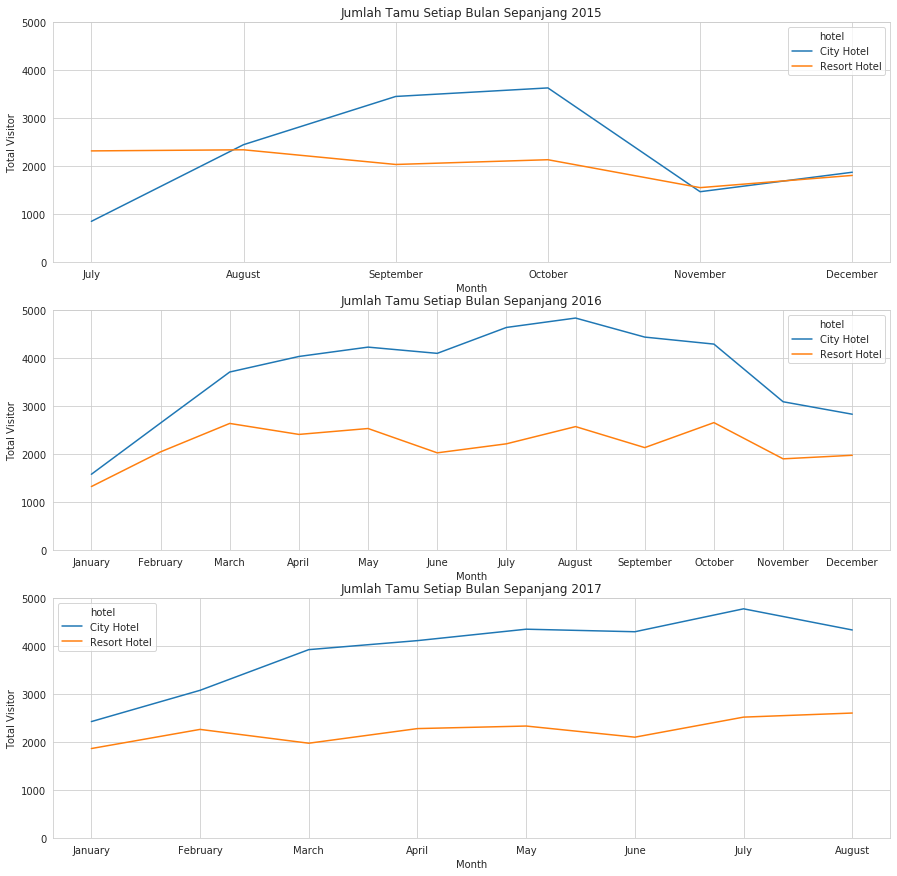

In [0]:
guests_monthly['arrival_date_month'] = pd.Categorical(guests_monthly['arrival_date_month'], categories=months, ordered=True)
guests_monthly = guests_monthly.groupby(['hotel', 'arrival_date_year', 'arrival_date_month'], as_index = False).sum()

f, ax = plt.subplots(3,1,figsize=(15,15))
sns.lineplot(x = 'arrival_date_month', y="total visitors", hue="hotel", data=guests_monthly[guests_monthly['arrival_date_year'] == 2015],  ci="sd", ax=ax[0])
sns.lineplot(x = 'arrival_date_month', y="total visitors", hue="hotel", data=guests_monthly[guests_monthly['arrival_date_year'] == 2016],  ci="sd", ax=ax[1])
sns.lineplot(x = 'arrival_date_month', y="total visitors", hue="hotel", data=guests_monthly[guests_monthly['arrival_date_year'] == 2017],  ci="sd", ax=ax[2])

ax[0].set(title="Jumlah Tamu Setiap Bulan Sepanjang 2015")
ax[0].set(xlabel="Month", ylabel="Total Visitor")
ax[0].set(ylim = (0,5000))

ax[1].set(title="Jumlah Tamu Setiap Bulan Sepanjang 2016")
ax[1].set(xlabel="Month", ylabel="Total Visitor")
ax[1].set(ylim = (0,5000))

ax[2].set(title="Jumlah Tamu Setiap Bulan Sepanjang 2017")
ax[2].set(xlabel="Month", ylabel="Total Visitor")
ax[2].set(ylim = (0,5000))

plt.show()

Dapat kita lihat bahwa dari grafik yang terlampir diatas bahwa 

### **4. Jumlah harga yang dibayarkan berdasarkan tipe kamar per malamnya**

In [0]:
# Membagi data berdasarkan hotel (Resort Hotel dan City Hotel) yang tidak di cancel
rh = data_no_outlier[(data_no_outlier['hotel'] == 'Resort Hotel') & (data_no_outlier['is_canceled'] == 0)]
ch = data_no_outlier[(data_no_outlier['hotel'] != 'Resort Hotel') & (data_no_outlier['is_canceled'] == 0)]

In [0]:
# menghitung ADR (Average Daily Rate) untuk perorangan (pengecualian untuk bayi)
rh['adr_pp'] = rh['adr'] / (rh['adults'] + rh['children'])
ch['adr_pp'] = ch['adr'] / (ch['adults'] + ch['children'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Dikarenakan hotel ini memiliki banyak pengunjung yang berasal dari Portugal, maka kemungkinan besar mata uang yang digunakan adalah Euro €. 

In [0]:
print(f"""
    Rata-rata harga yang dibayarkan oleh per orang per malam adalah:
    Resort Hotel: {rh['adr_pp'].mean():.2f} €
    City Hotel: {ch['adr_pp'].mean():.2f} €""" 
    )


    Rata-rata harga yang dibayarkan oleh per orang per malam adalah:
    Resort Hotel: 44.50 €
    City Hotel: 58.82 €


In [0]:
full_data_guests = data.copy()
full_data_guests = full_data_guests.loc[full_data_guests['is_canceled'] == 0]
full_data_guests['adr_pp'] = full_data_guests['adr'] / (full_data_guests['adults'] + full_data_guests['children'])
room_prices = full_data_guests[['hotel', 'reserved_room_type', 'adr_pp']].sort_values("reserved_room_type")

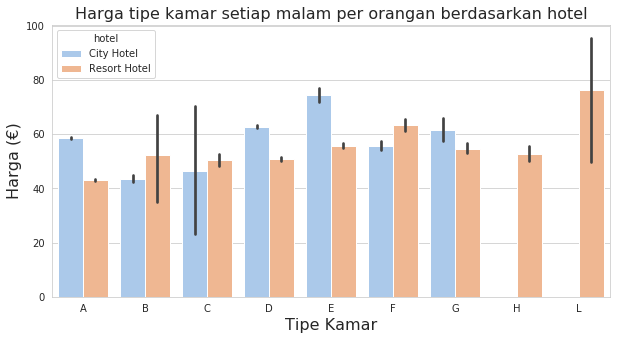

In [0]:
plt.figure(figsize=(10,5))
sns.barplot(x='reserved_room_type', y='adr_pp', hue='hotel', data=room_prices, hue_order=['City Hotel', 'Resort Hotel'], palette='pastel')
plt.title('Harga tipe kamar setiap malam per orangan berdasarkan hotel', fontsize=16)
plt.xlabel('Tipe Kamar', fontsize = 16)
plt.ylabel('Harga (€)', fontsize = 16)
plt.show()

BACOT SINI

### **5. Tipe Kamar Yang Paling Banyak dipesan**

In [0]:
print('Frekuensi pemesanan tiap-tiap tipe kamar pada CITY HOTEL')
print(data[(data['hotel'] == 'City Hotel')]['reserved_room_type'].value_counts())
print()
print('Frekuensi pemesanan tiap-tiap tipe kamar pada RESORT HOTEL')
print(data[data['hotel'] != 'City Hotel']['reserved_room_type'].value_counts())

Frekuensi pemesanan tiap-tiap tipe kamar pada CITY HOTEL
A    62484
D    11747
F     1788
E     1537
B     1112
G      482
C       13
Name: reserved_room_type, dtype: int64

Frekuensi pemesanan tiap-tiap tipe kamar pada RESORT HOTEL
A    23389
D     7432
E     4982
G     1610
F     1106
C      918
H      601
L        6
B        3
Name: reserved_room_type, dtype: int64


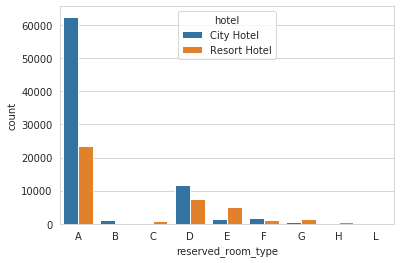

In [0]:
sns.countplot(x = 'reserved_room_type', data = data.sort_values('reserved_room_type'), hue='hotel') 

### **6. Perbandingan `market_segment` berdasarkan hotel**

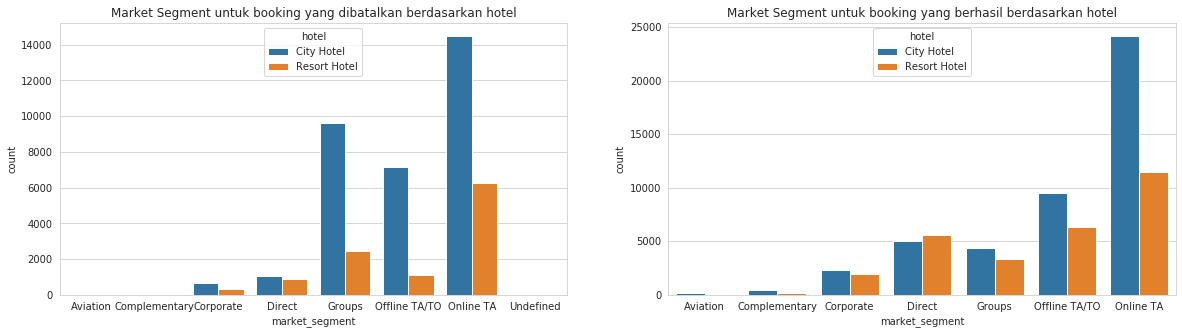

In [0]:
data_canceled = data[data['is_canceled'] == 1].sort_values('market_segment')
data_not_canceled = data[data['is_canceled'] == 0].sort_values('market_segment')
f, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data=data_canceled, x= 'market_segment', hue='hotel', ax =ax[0])
sns.countplot(data=data_not_canceled, x= 'market_segment', hue='hotel', ax =ax[1])
ax[0].set(title='Market Segment untuk booking yang dibatalkan berdasarkan hotel')
ax[1].set(title='Market Segment untuk booking yang berhasil berdasarkan hotel')
plt.show()

BACOT DI SINI

### **7. Korelasi setiap feature yang ada**

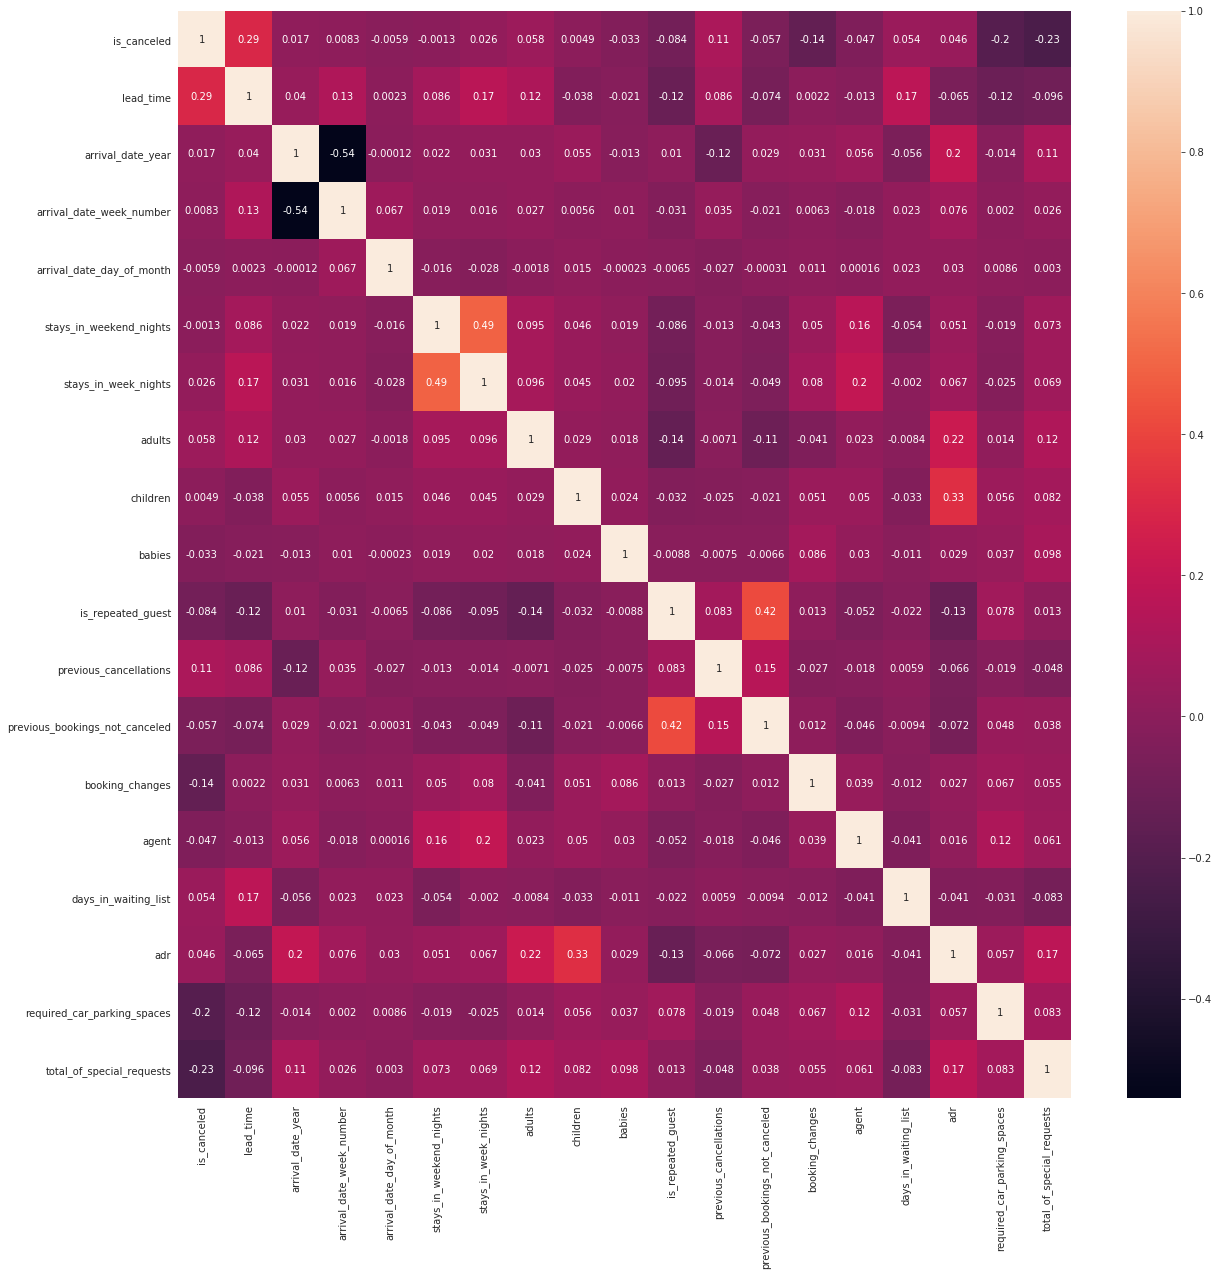

In [0]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True)

Dapat kita lihat disini bahwa terdapat korelasi yang kuat antara beberapa hal:
1. lead_time dengan is_cancelled

Peluang pembatalan pemesanan akan jauh lebih tinggi terjadi pada pelanggan yang melakukan pemesanan dari jauh hari karena rencana yang sudah direncanakan dari jauh hari lebih mungkin untuk berubah karena peristiwa yang tidak terduga. Faktor lain yang mungkin menjadi alasan mengapa pelanggan membatalkan pemesanan yang dilakukan dari jauh hari (yang seringkali dipermudah dengan opsi untuk melakukannya secara gratis) adalah karena perubahan rencana, bencana alam, atau penyakit yang datang secara mendadak.
2. previous_bookings_not_cancelled dengan is_repeated

Dapat kita simpulkan dari data yang terdapat disini bahwa sebagian besar dari pelanggan yang melakukan pemesanan order secara berulang tidak membatalkan pemesanan di pemesanan mereka sebelumnya dikarenakan mereka puas dengan pelayanan yang ada di hotel. Dari sini kita dapat mengetahui bahwa jika kita dapat mengurangi tingkat pembatalan pada pemesananan hotel, kita akan mempunyai peluang lebih tinggi untuk meningkatkan jumlah pelanggan yang akan melakukan pemesananan secara berulang 



### **8. Persentase Orang dewasa yang membawa anak dengan yang tidak**


In [0]:
adult_only = data[(data['adults'] != 0) & (data['children'] == 0) & (data['babies'] == 0)].sort_values('reserved_room_type')
adult_child = data[(data['adults'] != 0) & (data['children'] != 0) | (data['babies'] != 0)].sort_values('reserved_room_type')

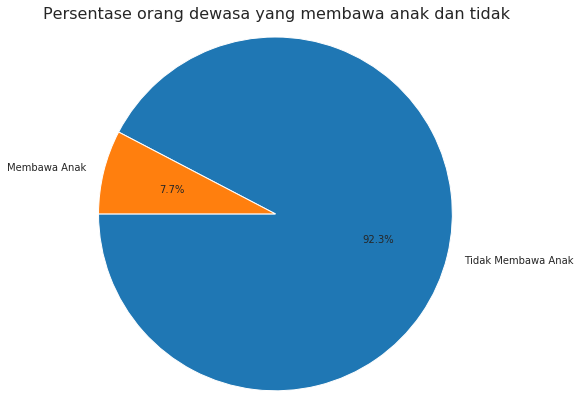

In [0]:
percentage = [(len(adult_only)/(len(adult_only) + len(adult_child)))*100, (len(adult_child)/(len(adult_only) + len(adult_child)))*100]
labels = 'Tidak Membawa Anak', 'Membawa Anak'

f, ax = plt.subplots(figsize=(7,7))
ax.pie(percentage, labels = labels, autopct='%1.1f%%' , startangle = 180)
ax.axis('equal')

ax.set_title('Persentase orang dewasa yang membawa anak dan tidak', fontsize=16)
plt.show()

### **9. Berapa banyak booking yang di cancel?**

Dari sini kita dapat melihat bahwa lebih banyak cancellation yang terjadi saat proses booking terjadi di city hotel daripada resort hotel. Ini dapat terjadi mungkin karena orang yang memesan di resort hotel yang terletak di daerah yang cenderung lebih sunyi dan jauh dari perkotaan , memang sudah jelas ingin liburan. Hal ini berbanding terbalik dengan proses booking yang terjadi di city hotel.  

In [0]:
total_cancelations = data['is_canceled'].sum()
rh_cancelations = data.loc[data["hotel"] == "Resort Hotel"]["is_canceled"].sum()
ch_cancelations = data.loc[data["hotel"] == "City Hotel"]["is_canceled"].sum()

# mencari persentase
rel_cancel = (total_cancelations / data.shape[0]) * 100
rh_rel_cancel = (rh_cancelations / data.loc[data["hotel"] == "Resort Hotel"].shape[0]) * 100
ch_rel_cancel = (ch_cancelations / data.loc[data["hotel"] == "City Hotel"].shape[0]) * 100

print(f"Banyak Booking yang dicancel: {total_cancelations:} ({rel_cancel:.0f} %)")
print(f"Banyak booking Resort hotel yang dicancel: {rh_cancelations:} ({rh_rel_cancel:.0f} %)")
print(f"Banyak booking City hotel yang dicancel: {ch_cancelations:} ({ch_rel_cancel:.0f} %)")

Banyak Booking yang dicancel: 44199 (37 %)
Banyak booking Resort hotel yang dicancel: 11120 (28 %)
Banyak booking City hotel yang dicancel: 33079 (42 %)


### **10. Berapa banyak total cancel setiap bulannya?**

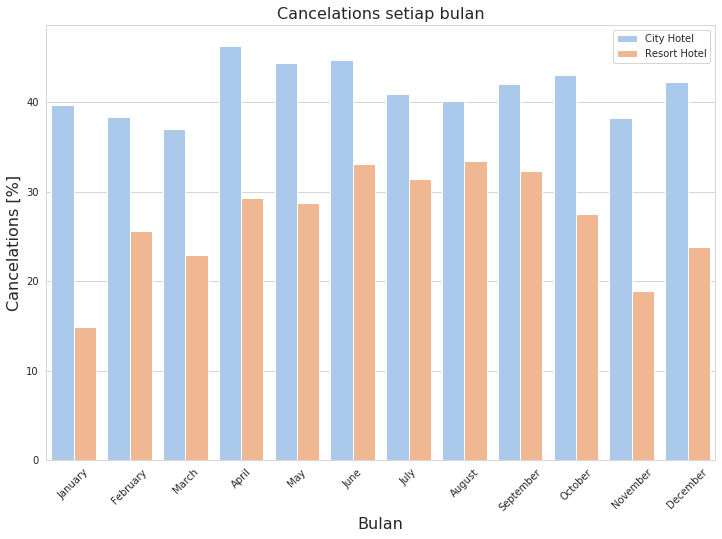

In [0]:
res_book_per_month = data.loc[(data["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = data.loc[(data["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

cty_book_per_month = data.loc[(data["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
cty_cancel_per_month = data.loc[(data["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})

cty_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(cty_book_per_month.index),
                                "Bookings": list(cty_book_per_month.values),
                                "Cancelations": list(cty_cancel_per_month.values)})

full_cancel_data = pd.concat([res_cancel_data, cty_cancel_data], ignore_index=True)
full_cancel_data["cancel_percent"] = full_cancel_data["Cancelations"] / full_cancel_data["Bookings"] * 100

ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
full_cancel_data["Month"] = pd.Categorical(full_cancel_data["Month"], categories=ordered_months, ordered=True)

plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=full_cancel_data, palette = 'pastel')
plt.title("Cancelations setiap bulan", fontsize=16)
plt.xlabel("Bulan", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.legend(loc="upper right")
plt.show()

BACOT DI SINI

### **11. Banyak Pembatalan berdasarkan `market_segment`**

Dapat dilihat dari grafik bahwa pembatalan pemesanan paling banyak terjadi di online travel agent karena kemudahan dalam memesan dan membatalkan yang ditawarkan oleh pihak online travel agent. Hal ini membuat calon pelangga jadi tidak berpikir 2 kali untuk memesan hotel karena kemudahan yang ditawarkan serta biaya pembatalan yang sering gratis. Kombinasi dari beberapa hal ini menyebabkan tingginya pembatalan ada pemesananan tiket lewat online travel agent. 

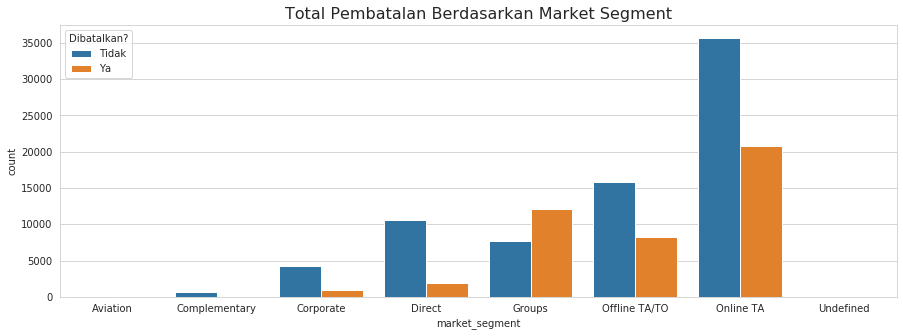

In [0]:
plt.figure(figsize=(15,5))
sns.countplot(x='market_segment', data=data.sort_values('market_segment'), hue = 'is_canceled')

plt.legend(title='Dibatalkan?', loc='best', labels=['Tidak', 'Ya'])
plt.title('Total Pembatalan Berdasarkan Market Segment', size = 16)
plt.show()

### **12. Distribusi ADR**

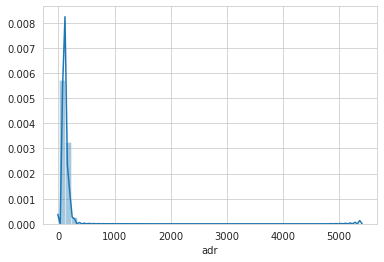

In [0]:
sns.distplot(data[data['adr'] > 0]['adr'])

## Machine Learning Modelling

Setelah melakukan observasi, maka didapati ada beberapa fitur yang dianggap tidak perlu. Oleh karena itu pemilihan ini dilakukan secara manual.

In [0]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier, plot_importance, DMatrix, train
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [0]:
dtrain = pd.read_csv('https://raw.githubusercontent.com/kevinasyraf/find-it-2020-dac/master/hotel_bookings.csv')

In [0]:
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
dtrain = dtrain.fillna(nan_replacements)

# "meal" contains values "Undefined", which is equal to SC.
dtrain["meal"].replace("Undefined", "SC", inplace=True)

In [0]:
dtrain=dtrain.drop(['company'],axis=1)
dtrain=dtrain.dropna(axis=0)

In [0]:
dtrain.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces 

### Label Encoding

Setiap data categorical akan kita encode menjadi sebuah angka. ini bertujuan agar memudahkan melakukan train pada machine learning karena mesin lebih mudah menerima data berupa angka dibanding string.

In [0]:
# hotel
dtrain['hotel']=dtrain['hotel'].map({'Resort Hotel':0,'City Hotel':1})
dtrain['hotel'].unique()

array([0, 1])

In [0]:
# arrival_date_month
dtrain['arrival_date_month'] = dtrain['arrival_date_month'].map({'July':7,'August':8,'September':9,'October':10
                                                                ,'November':11,'December':12,'January':1,'February':2,'March':3,
                                                                'April':4,'May':5,'June':6})
dtrain['arrival_date_month'].unique()

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6])

Sekarang kita akan memanfaatkan library LabelEncoder. Jauh lebih cepat dan efisien ketimbang mendefinisikan value dari data categoricalnya satu-satu.

In [0]:
label_encoder = LabelEncoder()

In [0]:
dtrain['meal']=label_encoder.fit_transform(dtrain['meal'])
dtrain['meal'].unique()

array([0, 1, 2, 3])

In [0]:
dtrain['country']=label_encoder.fit_transform(dtrain['country'])
dtrain['market_segment']=label_encoder.fit_transform(dtrain['market_segment'])
dtrain['distribution_channel']=label_encoder.fit_transform(dtrain['distribution_channel'])
dtrain['reserved_room_type']=label_encoder.fit_transform(dtrain['reserved_room_type'])
dtrain['assigned_room_type']=label_encoder.fit_transform(dtrain['assigned_room_type'])
dtrain['deposit_type']=label_encoder.fit_transform(dtrain['deposit_type'])
dtrain['customer_type']=label_encoder.fit_transform(dtrain['customer_type'])
dtrain['reservation_status']=label_encoder.fit_transform(dtrain['reservation_status'])
dtrain['reservation_status_date']=label_encoder.fit_transform(dtrain['reservation_status_date'])

In [0]:
dtrain.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,0,342,2015,7,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,3,0,0.0,0,2,0.0,0,0,1,668
1,0,0,737,2015,7,27,1,0,0,2,0.0,0,0,135,3,1,0,0,0,2,2,4,0,0.0,0,2,0.0,0,0,1,668
2,0,0,7,2015,7,27,1,0,1,1,0.0,0,0,59,3,1,0,0,0,0,2,0,0,0.0,0,2,75.0,0,0,1,701
3,0,0,13,2015,7,27,1,0,1,1,0.0,0,0,59,2,0,0,0,0,0,0,0,0,304.0,0,2,75.0,0,0,1,701
4,0,0,14,2015,7,27,1,0,2,2,0.0,0,0,59,6,3,0,0,0,0,0,0,0,240.0,0,2,98.0,0,1,1,734


### Feature Extraction

In [0]:
# Gathering which feature is more important.....using corr() function
correlation=dtrain.corr()['is_canceled']
correlation.abs().sort_values(ascending=False)

is_canceled                       1.000000
reservation_status                0.917191
deposit_type                      0.468665
lead_time                         0.293177
country                           0.264709
total_of_special_requests         0.234706
required_car_parking_spaces       0.195492
assigned_room_type                0.176025
distribution_channel              0.167544
booking_changes                   0.144371
reservation_status_date           0.143258
hotel                             0.136505
previous_cancellations            0.110140
is_repeated_guest                 0.084788
customer_type                     0.068210
reserved_room_type                0.061284
adults                            0.059990
market_segment                    0.059314
previous_bookings_not_canceled    0.057355
days_in_waiting_list              0.054193
adr                               0.047622
agent                             0.046503
babies                            0.032488
stays_in_we

In [0]:
cols=['arrival_date_day_of_month','children',
     'arrival_date_week_number','stays_in_week_nights','reservation_status']
dtrain=dtrain.drop(cols,axis=1)
dtrain.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,stays_in_weekend_nights,adults,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
0,0,0,342,2015,7,0,2,0,0,135,3,1,0,0,0,2,2,3,0,0.0,0,2,0.0,0,0,668
1,0,0,737,2015,7,0,2,0,0,135,3,1,0,0,0,2,2,4,0,0.0,0,2,0.0,0,0,668
2,0,0,7,2015,7,0,1,0,0,59,3,1,0,0,0,0,2,0,0,0.0,0,2,75.0,0,0,701
3,0,0,13,2015,7,0,1,0,0,59,2,0,0,0,0,0,0,0,0,304.0,0,2,75.0,0,0,701
4,0,0,14,2015,7,0,2,0,0,59,6,3,0,0,0,0,0,0,0,240.0,0,2,98.0,0,1,734


In [0]:
dtrain.shape

(119386, 26)

### Membangun Model

In [0]:
y=dtrain['is_canceled'].values
x=dtrain.drop(['is_canceled'],axis=1).values

In [0]:
# dataset split.
train_size=0.80
test_size=0.20
seed=5

x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=train_size,test_size=test_size,random_state=seed)

In [0]:
ensembles=[]
ensembles.append(('scaledRFC',Pipeline([('scale',StandardScaler()),('rf',RandomForestClassifier(n_estimators=10))])))

results=[]
names=[]
for name,model in ensembles:
    fold = KFold(n_splits=10,random_state=5)
    result = cross_val_score(model,x_train,y_train,cv=fold,scoring='accuracy')
    results.append(result)
    names.append(name)
    msg="%s : %f (%f)"%(name,result.mean(),result.std())
    print(msg)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



scaledRFC : 0.931576 (0.002612)


Berdasarkan training model di atas menggunakan RFC dan standardscaler, maka di dapatkan hasil akurasinya Random Forest Classifier **0.931576 (0.002612)**

In [0]:
# Random Forest Classifier Tuning
from sklearn.model_selection import GridSearchCV

scaler=StandardScaler().fit(x_train)
rescaledx=scaler.transform(x_train)

n_estimators=[10,20,30,40,50]

param_grid=dict(n_estimators=n_estimators)

model=RandomForestClassifier()

fold=KFold(n_splits=10,random_state=0)

grid=GridSearchCV(estimator=model,param_grid=param_grid,scoring='accuracy',cv=fold)
grid_result=grid.fit(rescaledx,y_train)

print("Best: %f using %s "%(grid_result.best_score_,grid_result.best_params_))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



Best: 0.940309 using {'n_estimators': 40} 


#### Random Forest

Berdasarkan hasil kedua tuning di atas. Maka Random Forest akan digunakan untuk melakukan prdiksi dari data kita. 

In [0]:
from sklearn.metrics import confusion_matrix

scaler=StandardScaler().fit(x_train)
scaler_x=scaler.transform(x_train)
model=RandomForestClassifier(n_estimators=40)
model.fit(scaler_x,y_train)

#Transform the validation test set data
scaledx_test=scaler.transform(x_test)
y_pred=model.predict(scaledx_test)

accuracy_mean=accuracy_score(y_test,y_pred)
accuracy_matric=confusion_matrix(y_test,y_pred)
print(accuracy_mean)
print(accuracy_matric)

0.944132674428344
[[14698   304]
 [ 1030  7846]]


In [0]:
# prediksi keseluruhan data dengan mentransform datanya terlebih dahulu
y_pred = model.predict(scaler.transform(x))
print(accuracy_score(y, y_pred))

0.9886418843080428


Dan kita berhasil mendapatkan akurasi sebesar 98,86 % :D


In [0]:
predicted_data = pd.DataFrame({'is_canceled' : pd.Series(y_pred)})
predicted_data.head(10)

,is_canceled
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,1
9,1


In [0]:
# saatnya untuk mengexport hasil prediksi ke dalam file excel
predicted_data.to_excel('ORANG_TUA_UNIVERSITAS_INDONESIA_IQRAR_AGALOSI_NUREYZA.xlsx', index=False)

In [0]:
predicted_data.shape

(119386, 1)